# Rendering from the saved rollout h5 file

This notebook will show you how to load the saved rollout, and create a rendering video from that, with further visual analysis pipeline to visualize the agents, i.e. temporal dynamics of the intentions.

In [6]:
# imports
import os

os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

from typing import List
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.animation as animation

from sklearn.decomposition import PCA
from PIL import Image
from IPython.display import HTML


from track_mjx.environment.task.multi_clip_tracking import MultiClipTracking
from track_mjx.environment.walker.rodent import Rodent

import mujoco
from pathlib import Path
from dm_control import mjcf as mjcf_dm
from dm_control.locomotion.walkers import rescale
import imageio
import numpy as np

import multiprocessing as mp
import functools

# Rendering Related Helper Functions

In [95]:
def agg_backend_context(func):
    """
    Decorator to switch to a headless backend during function execution.
    """

    def wrapper(*args, **kwargs):
        orig_backend = matplotlib.get_backend()
        matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
        # Code to execute BEFORE the original function
        result = func(*args, **kwargs)
        # Code to execute AFTER the original function
        plt.close("all")  # Figure auto-closing upon backend switching is deprecated.
        matplotlib.use(orig_backend)
        return result

    return wrapper


def render_from_saved_rollout(
    rollout: dict,
) -> list:
    """
    Render a rollout from saved qposes.

    Args:
        rollout (dict): A dictionary containing the qposes of the reference and rollout trajectories.

    Returns:
        list: list of frames of the rendering
    """
    qposes_ref, qposes_rollout = rollout["qposes_ref"], rollout["qposes_rollout"]
    # need to change to the new xml file
    pair_render_xml_path = (
        "/root/vast/scott-yang/track-mjx/track_mjx/environment/walker/assets/rodent/rodent_ghostpair_scale080.xml"
    )
    # TODO: Make this ghost rendering walker agonist
    root = mjcf_dm.from_path(pair_render_xml_path)
    rescale.rescale_subtree(
        root,
        0.9 / 0.8,
        0.9 / 0.8,
    )

    mj_model = mjcf_dm.Physics.from_mjcf_model(root).model.ptr
    mj_model.opt.solver = {
        "cg": mujoco.mjtSolver.mjSOL_CG,
        "newton": mujoco.mjtSolver.mjSOL_NEWTON,
    }["cg"]
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6
    mj_data = mujoco.MjData(mj_model)

    # save rendering and log to wandb
    mujoco.mj_kinematics(mj_model, mj_data)
    renderer = mujoco.Renderer(mj_model, height=480, width=640)
    frames = []
    print("MuJoCo Rendering...")
    for qpos1, qpos2 in tqdm(zip(qposes_rollout, qposes_ref), total=len(qposes_rollout)):
        mj_data.qpos = np.append(qpos1, qpos2)
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(
            mj_data,
            camera="close_profile",
        )
        pixels = renderer.render()
        frames.append(pixels)
    return frames


def plot_pca_intention(
    idx,
    episode_start,
    pca_projections: np.ndarray,
    clip_idx: int,
    feature_name: str,
    n_components: int = 4,
    terminated=False,
):
    """
    plot pca intention progression of the episode
    Args:
        idx: the current timestep
        episode_start: the start timestep of the episode
        pca_projections: the pca projection of the episode, shape (timestep, n_components)
        clip_idx: the clip index
        feature_name: the feature name
        n_components: the number of pca components to plot
        ylim: the y-axis limit
        terminated: whether the episode is terminated

    """
    max_y = np.max(list(pca_projections[:, :n_components]))
    min_y = np.min(list(pca_projections[:, :n_components]))
    y_lim = (min_y - 0.2, max_y + 0.2)
    window_size = 530
    idx_in_this_episode = idx - episode_start  # the current timestep in this episode
    plt.figure(figsize=(9.6, 4.8))
    for pc_ind in range(n_components):
        # Plot the PCA projection of the episode
        plt.plot(
            pca_projections[episode_start:idx, pc_ind],
            label=f"PC {pc_ind} ({pca.explained_variance_ratio_[pc_ind]*100:.1f}%)",
        )
        plt.scatter(idx - episode_start, pca_projections[idx - 1, pc_ind])
    if terminated:
        # Mark the episode termination
        plt.axvline(x=idx - episode_start, color="r", linestyle="-")
        plt.text(
            idx - episode_start - 8,  # Adjust the x-offset as needed
            sum(y_lim) / 2,  # Adjust the y-position as needed
            "Episode Terminated",
            color="r",
            rotation=90,
        )  # Rotate the text vertically
    if idx_in_this_episode <= window_size:
        plt.xlim(0, window_size)
    else:
        plt.xlim(idx_in_this_episode - window_size, idx_in_this_episode)  # dynamically move xlim as time progress
    plt.ylim(*y_lim)
    plt.legend(loc="upper right")
    plt.xlabel("Timestep")
    plt.title(f"PCA {feature_name} Progression for Clip {clip_idx}")  # TODO make it configurable
    # Get the current figure
    fig = plt.gcf()
    # Create a canvas for rendering
    canvas = FigureCanvasAgg(fig)
    # Render the canvas to a buffer
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    # Convert the buffer to a PIL Image
    image = Image.frombytes("RGBA", (width, height), s)
    rgb_array = np.array(image.convert("RGB"))
    return rgb_array


def render_with_pca_progression(
    rollout: dict, pca_projections: np.ndarray, n_components: int = 4, feature_name: str = "ctrl"
):
    """
    render with the rewards progression graph concat alongside with the rendering
    """
    frames_mujoco = render_from_saved_rollout(rollout)[1:]
    # skip the first frame, since we don't have intention for the first frame
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    clip_idx = int(rollout["info"][0]["clip_idx"])
    worker = functools.partial(
        plot_pca_intention,
        episode_start=0,
        clip_idx=clip_idx,
        pca_projections=pca_embedded,
        n_components=n_components,
        feature_name=feature_name,
    )
    print("Rendering with PCA progression...")
    # Use multiprocessing to parallelize the rendering of the reward graph
    with mp.Pool(processes=mp.cpu_count()) as pool:
        frames_pca = pool.map(worker, range(len(rollout["qposes_rollout"])))
    concat_frames = []
    episode_start = 0
    # implement reset logics of the reward graph too.
    print("Concatenating frames...")
    for idx, frame in tqdm(enumerate(frames_mujoco)):
        concat_frames.append(np.hstack([frame, frames_pca[idx]]))
    reward_plot = plot_pca_intention(
        len(frames_mujoco) - 1, episode_start, pca_projections, clip_idx, feature_name, n_components, terminated=True
    )
    plt.close("all")  # Figure auto-closing upon backend switching is deprecated.
    matplotlib.use(orig_backend)
    for _ in range(50):
        concat_frames.append(np.hstack([frames_mujoco[-1], reward_plot]))  # create stoppage when episode terminates
    return concat_frames


def display_video(frames, framerate=30):
    """
    Args:
        frames (array): (n_frames, height, width, 3)
        framerate (int): the framerate of the video
    """
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.close("all")  # Figure auto-closing upon backend switching is deprecated.
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

## Step 1: Load the rollout file from the `.h5` file

In [7]:
import h5py


def load_from_h5py(file, group_path="/") -> dict:
    """
    Load a pytree structure from an HDF5 file.

    Args:
        file (h5py.File): An open HDF5 file object.
        group_path (str): The HDF5 group path to read data from.

    Returns:
        The reconstructed data structure.
    """
    group = file[group_path]
    if isinstance(group, h5py.Dataset):
        return group[()]  # Read dataset value
    elif isinstance(group, h5py.Group):
        if all(k.isdigit() for k in group.keys()):  # Likely a list
            return [load_from_h5py(file, f"{group_path}/{k}") for k in sorted(group.keys(), key=int)]
        else:  # Dictionary-like group
            return {k: load_from_h5py(file, f"{group_path}/{k}") for k in group.keys()}
    else:
        raise TypeError(f"Unsupported group type: {type(group)}")


# Example usage
with h5py.File("/root/vast/scott-yang/rodent_rollout_info/data/clip_1.h5", "r") as h5file:
    rollout = load_from_h5py(h5file)

In [3]:
# directly get out the activations
with h5py.File("/root/vast/scott-yang/rodent_rollout_info/data/clip_1.h5", "r") as h5file:
    activations = load_from_h5py(h5file, group_path="/activations")
    intentions = [a["intention"] for a in activations]

In [4]:
activations[0]["decoder"]["layer_1"]

array([-3.77515435e-01, -8.32271129e-02, -2.30948657e-01, -9.48300481e-01,
       -5.52019596e-01,  1.19356036e+00, -7.53828228e-01,  1.98292267e+00,
       -8.14293027e-01, -9.28100169e-01,  4.00854290e-01, -4.79457974e-01,
       -6.22629464e-01, -4.87674773e-01, -5.61166763e-01, -5.47189295e-01,
       -9.86986011e-02, -6.86106443e-01, -6.63601518e-01, -4.14085597e-01,
        1.79018855e-01,  1.22406617e-01, -7.74092197e-01, -7.52440274e-01,
       -1.25922889e-01, -5.75854421e-01, -3.40844035e-01, -6.64034605e-01,
       -5.77418923e-01,  3.90730500e-02, -4.47339863e-01,  7.94113338e-01,
       -9.29510117e-01, -8.85931313e-01, -7.75797665e-01,  2.01058960e+00,
       -8.11083317e-01, -6.64673924e-01, -1.95121706e-01, -1.16255116e+00,
        2.65991712e+00, -7.62169778e-01, -3.29727083e-01,  1.96104324e+00,
       -7.95091331e-01, -4.74148929e-01, -5.00879645e-01, -7.53414512e-01,
        1.98091733e+00,  3.92666787e-01, -7.18066335e-01,  2.78889239e-01,
       -4.84028071e-01,  

# Analysis: PCA for all intentions across rollout

The following cell traverse though the recorded rollout `.h5` file in the directly, and parse out the intentions of each episode. All of the intentions vectors are aggregated into a single matrix for PCA analysis

In [18]:
def get_aggregate_data(group_path, keys: List[str], clip_idx: int):
    """
    Get the aggregate data from the hdf5 file
    """
    with h5py.File(f"/root/vast/scott-yang/rodent_rollout_info/data/clip_{clip_idx}.h5", "r") as h5file:
        data = load_from_h5py(h5file, group_path=group_path)
        for key in keys:
            if type(data) == list and type(data[0]) == dict:
                data = [d[key] for d in data]
            elif type(data) == dict:
                data = data[key]
            else:
                raise ValueError("Data structure not supported")
    return data

# MultiProcessing SpeedUp

this will take 0.63 * 850 = 535 seconds = 8.9 minutes to run, if I run it in a ordinary for loop

In [89]:
%%timeit
# if I wanna get the activations for the decoder layer 0 of clip 1
get_aggregate_data("/activations", ["decoder", "layer_0"], 1)

# this will take 0.63 * 850 = 535 seconds = 8.9 minutes to run

623 ms ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 However, if I multiprocessing the IO call, we only need 26 seconds to complete the call. 

In [106]:
import multiprocessing as mp
from tqdm import tqdm

work = functools.partial(get_aggregate_data, "/activations", ["decoder", "layer_2"])

with mp.Pool(processes=mp.cpu_count()) as pool:
    activations = list(tqdm(pool.imap(work, range(842)), total=842))

activations = np.vstack(activations)

/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


100%|██████████| 842/842 [00:17<00:00, 48.04it/s]


In [107]:
activations.shape

(420158, 512)

In [108]:
pca = PCA()

pca = pca.fit(activations)
print(np.cumsum(pca.explained_variance_ratio_[:10]))
pca_embedded = pca.transform(activations)

[0.26773492 0.38889253 0.5020172  0.5744773  0.6349618  0.6788612
 0.7131454  0.7458761  0.7747429  0.7954064 ]


## Serialized the PCA result to disk

In this way, we can directly load the pca object to do the transformation.

In [109]:
# Serialize PCA components to a dictionary
pca_data = {
    "components_": pca.components_.tolist(),
    "explained_variance_": pca.explained_variance_.tolist(),
    "explained_variance_ratio_": pca.explained_variance_ratio_.tolist(),
    "mean_": pca.mean_.tolist(),
    "n_components_": pca.n_components_,
}

# Save to a JSON file
with open("pca_decoder_activations_layer_2_rodent.json", "w") as f:
    json.dump(pca_data, f)

# Load the PCA object from json

In [115]:
with open("pca_intentions_rodent.json", "r") as f:
    loaded_pca_data = json.load(f)

# Reconstruct the PCA object
pca = PCA(n_components=loaded_pca_data["n_components_"])
pca.components_ = np.array(loaded_pca_data["components_"])
pca.explained_variance_ = np.array(loaded_pca_data["explained_variance_"])
pca.explained_variance_ratio_ = np.array(loaded_pca_data["explained_variance_ratio_"])
pca.mean_ = np.array(loaded_pca_data["mean_"])

In [14]:
pca_embedded = pca.transform(intentions)

/tmp/ipykernel_675802/1349517254.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_embedded[:, 0], pca_embedded[:, 1], cmap="tab20", alpha=0.3)


Text(0.5, 1.0, 'PCA of intentions across all episodes')

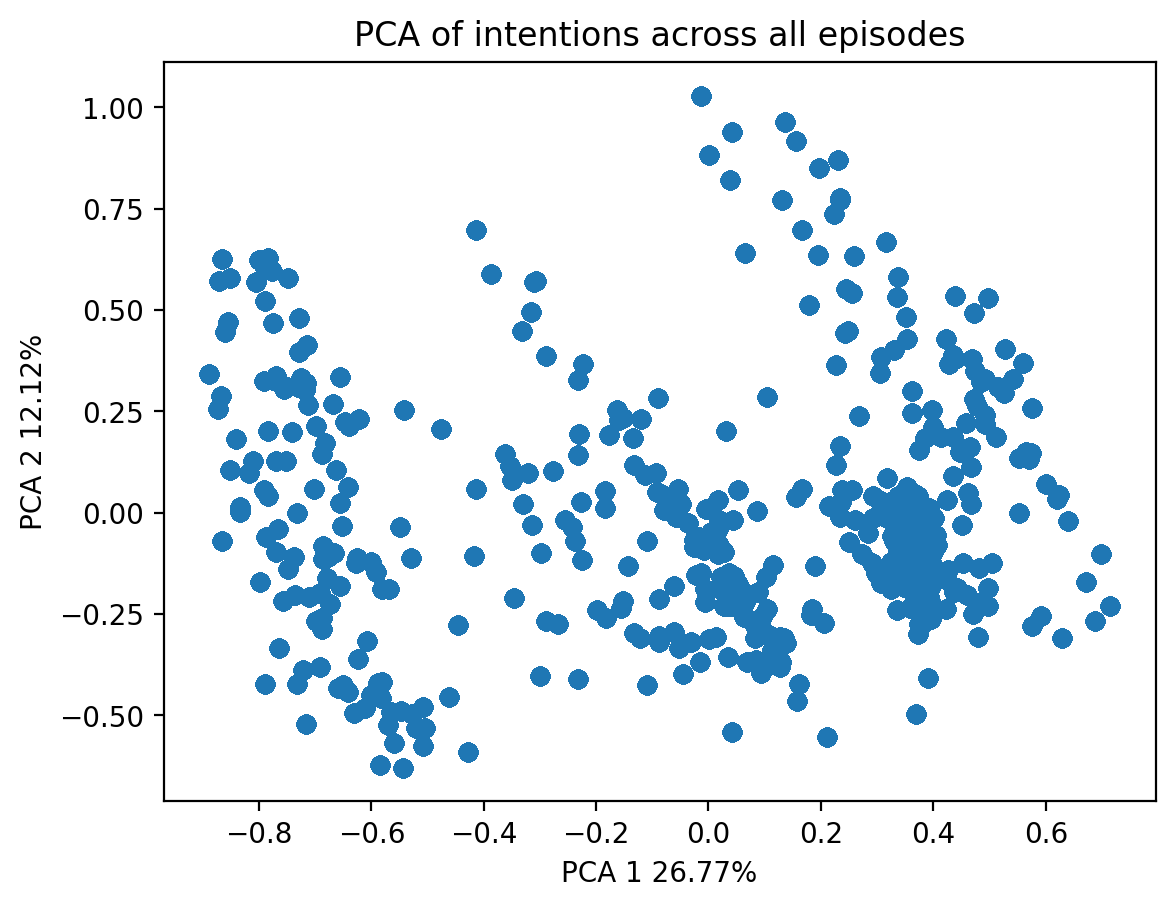

In [110]:
plt.scatter(pca_embedded[:, 0], pca_embedded[:, 1], cmap="tab20", alpha=0.3)
plt.xlabel(f"PCA 1 {pca.explained_variance_ratio_[0]*100:.2f}%")
plt.ylabel(f"PCA 2 {pca.explained_variance_ratio_[1]*100:.2f}%")
plt.title("PCA of intentions across all episodes")

In [113]:
clip_id = 39
with h5py.File(f"/root/vast/scott-yang/rodent_rollout_info/data/clip_{clip_id}.h5", "r") as h5file:
    rollout = load_from_h5py(h5file)
    # directly get out the activations
    act = get_aggregate_data("/activations", ["decoder", "layer_1"], clip_id)
pca_embedded = pca.transform(act)
frames = render_with_pca_progression(rollout, pca_embedded, n_components=5, feature_name="decoder layer 2")

MuJoCo Rendering...


100%|██████████| 500/500 [00:02<00:00, 214.14it/s]

Rendering with PCA progression...



/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Concatenating frames...


499it [00:00, 820.72it/s]


In [114]:
display_video(frames, framerate=30)

In [117]:
from IPython.display import clear_output

for i in tqdm(range(21, 842)):
    with h5py.File(f"/root/vast/scott-yang/rodent_rollout_info/data/clip_{clip_id}.h5", "r") as h5file:
        rollout = load_from_h5py(h5file)
        intentions = [a["intention"] for a in rollout["activations"]]
    pca_embedded = pca.transform(intentions)
    frames = render_with_pca_progression(rollout, pca_embedded, n_components=5, feature_name="intention")
    imageio.mimsave(
        f"/root/vast/scott-yang/rodent_rollout_info/videos_intentions_pca/rodent_clip_intention_{i}.mp4", frames, fps=30
    )
    clear_output(wait=True)

 62%|██████▏   | 510/821 [4:02:14<2:29:15, 28.79s/it]

MuJoCo Rendering...


100%|██████████| 500/500 [00:03<00:00, 158.02it/s]


Rendering with PCA progression...


/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [17]:
display_video(frames, framerate=30)

# Get the Labels of each clip id

In [40]:
with h5py.File("/root/vast/scott-yang/vnl_ray/clips/all_snippets.h5", "r") as h5file:
    group = h5file["clip_0/walkers/walker_0"]
    if isinstance(group, h5py.Dataset):
        print(group[()])  # Read dataset value
    else:
        print(group.keys())

<KeysViewHDF5 ['angular_velocity', 'appendages', 'body_positions', 'body_quaternions', 'center_of_mass', 'end_effectors', 'joints', 'joints_velocity', 'markers', 'position', 'quaternion', 'scaling', 'velocity']>


In [42]:
import pickle as pkl

with open("/root/vast/scott-yang/vnl_ray/clips/all_snips.p", "rb") as file:
    all_snips = pkl.load(file)

/tmp/ipykernel_675802/1311013403.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_675802/1311013403.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_675802/1311013403.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_675802/1311013403.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl

In [46]:
all_snips["snips_order"]

['././snippets_2_25_2021/snips/FastWalk_171.p',
 '././snippets_2_25_2021/snips/LGroom_158.p',
 '././snippets_2_25_2021/snips/FastWalk_169.p',
 '././snippets_2_25_2021/snips/FastWalk_44.p',
 '././snippets_2_25_2021/snips/RGroom_45.p',
 '././snippets_2_25_2021/snips/FastWalk_58.p',
 '././snippets_2_25_2021/snips/Rear_155.p',
 '././snippets_2_25_2021/snips/RGroom_16.p',
 '././snippets_2_25_2021/snips/Rear_82.p',
 '././snippets_2_25_2021/snips/Walk_145.p',
 '././snippets_2_25_2021/snips/Rear_175.p',
 '././snippets_2_25_2021/snips/RGroom_164.p',
 '././snippets_2_25_2021/snips/Walk_115.p',
 '././snippets_2_25_2021/snips/Walk_98.p',
 '././snippets_2_25_2021/snips/Rear_104.p',
 '././snippets_2_25_2021/snips/Rear_166.p',
 '././snippets_2_25_2021/snips/Walk_174.p',
 '././snippets_2_25_2021/snips/Rear_158.p',
 '././snippets_2_25_2021/snips/LGroom_134.p',
 '././snippets_2_25_2021/snips/Rear_5.p',
 '././snippets_2_25_2021/snips/Rear_135.p',
 '././snippets_2_25_2021/snips/FastWalk_87.p',
 '././snipp